# model selection

## import libs

In [1]:
import re
import string
from abc import ABC

from nltk.corpus import stopwords

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

What we want to do here is to try various models in these data sets, train them and validate the results based on multiple metrics. We also want to play with model inputs to check its result. We also need to tune model hyperparameters. As we are going to train and test the model multiple times with different configs, it would be beneficial to prepare some code in advance in order to prevent rewriting code.

## train, validation and test data sets split

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
from sklearn.model_selection import train_test_split

random_state_seed = 22
df_train_validation, df_test = train_test_split(df, test_size=0.2, random_state=random_state_seed)
df_train, df_validation = train_test_split(df_train_validation, test_size=0.25, random_state=random_state_seed)

In [4]:
import abc


class ModelInterface:
    @abc.abstractmethod
    def fit(self, x, y):
        pass

    @abc.abstractmethod
    def predict(self, x):
        pass

    def predict_proba(self, x):
        pass

In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, roc_curve, confusion_matrix, \
    ConfusionMatrixDisplay


class MetricsCalculator(object):
    def __init__(self, y_actual, y_probabilities):
        self.y_true = y_actual
        self.y_pred = y_probabilities
        self.threshold = 0.5

    def set_threshold(self, threshold):
        self.threshold = threshold

    def get_auc(self):
        return roc_auc_score(self.y_true, self.y_pred)

    def get_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred >= self.threshold)

    def get_recall(self):
        return recall_score(self.y_true, self.y_pred >= self.threshold)

    def get_precision(self):
        return precision_score(self.y_true, self.y_pred >= self.threshold)

    def get_confusion_matrix(self):
        return confusion_matrix(self.y_true, self.y_pred >= self.threshold)

    def show_confusion_matrix(self, axis=None):
        confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(self.y_true, (self.y_pred > self.threshold)))
        confusion_matrix_display.plot(cmap='magma', ax=axis)

    def show_roc_curve(self, axis=None):
        fpr, tpr, _ = roc_curve(self.y_true, self.y_pred)
        if axis is None:
            axis = plt
        axis.plot(fpr, tpr)
        axis.plot([0, 1], [0, 1])

In [6]:
from input_providers import InputProviderInterface


class TrainValidationWorkflow(object):
    def __init__(
            self,
            model: ModelInterface,
            input_provider: InputProviderInterface,
            df_train: pd.DataFrame,
            df_validation: pd.DataFrame = None
    ):
        self.model = model
        self.input_provider = input_provider
        self.df_train = df_train
        self.df_validation = df_validation

    def get_model(self):
        self._train_flow()
        return self.model

    def get_metrics_calculator(self) -> MetricsCalculator:
        self._train_flow()
        assert self.df_validation is not None, 'you should provide the validation dataframe'
        x_validation, y_validation = self.input_provider.get_test_inputs(self.df_validation)
        return MetricsCalculator(y_validation, self.model.predict_proba(x_validation)[:, 1])

    def _train_flow(self):
        x_train, y_train = self.input_provider.get_train_inputs(self.df_train)
        self.model.fit(x_train, y_train)

## Logistic regression

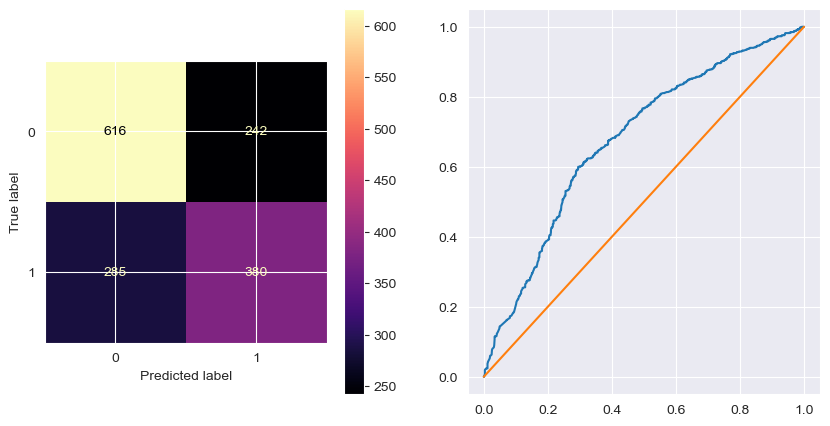

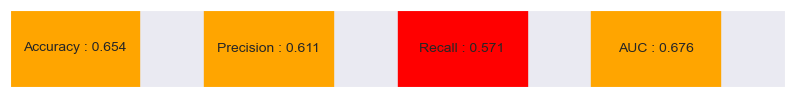

In [7]:
from sklearn.linear_model import LogisticRegression
from input_providers import *
from report import report

lrmodel = LogisticRegression()
lrflow = TrainValidationWorkflow(model=lrmodel, input_provider=InputProvider1(), df_train=df_train,
                                 df_validation=df_validation)
metrics = lrflow.get_metrics_calculator()
report(metrics)

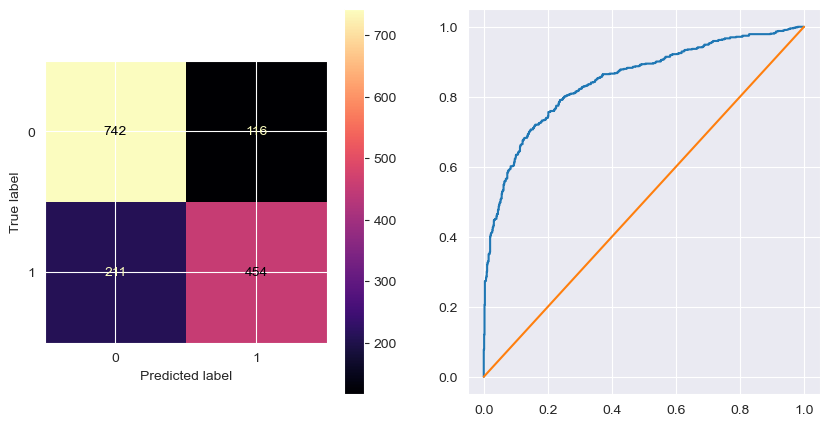

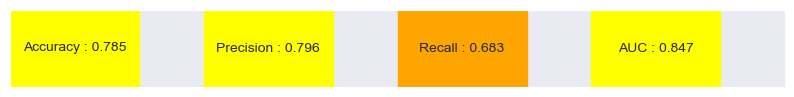

In [8]:
from sklearn.linear_model import LogisticRegression
from input_providers import *
from report import report

lrmodel = LogisticRegression()
lrflow = TrainValidationWorkflow(model=lrmodel, input_provider=InputProvider3(), df_train=df_train,
                                 df_validation=df_validation)
metrics = lrflow.get_metrics_calculator()
report(metrics)

In [ ]:
from sklearn.linear_model import LogisticRegression
from input_providers import *
from report import report

lrmodel = LogisticRegression()
lrflow = TrainValidationWorkflow(model=lrmodel, input_provider=InputProvider4(), df_train=df_train,
                                 df_validation=df_validation)
metrics = lrflow.get_metrics_calculator()
report(metrics)